In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [2]:
filenames = [file for file in tqdm(os.listdir("scripts"))]

100%|██████████| 2059/2059 [00:00<00:00, 4322358.33it/s]


In [4]:
movie_scripts = []

for file in filenames:
    with open(f"scripts/{file}", 'r') as f:
        movie_scripts = movie_scripts + [f.read()]

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


tagged_data = [TaggedDocument(words=script.split(), tags=[str(i)]) for i, script in enumerate(movie_scripts)]

model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=4, epochs=10)
model.build_vocab(tagged_data)


for epoch in tqdm(range(model.epochs), desc="Training Doc2Vec"):
    model.train(tagged_data, total_examples=model.corpus_count, epochs=1)
    model.alpha -= 0.002  
    model.min_alpha = model.alpha  


movie_vectors = [(title, model.dv[i].tolist()) for i, title in enumerate(filenames)]


Training Doc2Vec: 100%|██████████| 10/10 [04:48<00:00, 28.88s/it]


In [6]:
l = []
v = []

for pair in movie_vectors:
    l = l + [[pair[0][:-4].replace("-", " ")] + pair[1]]



In [7]:
dfscript = pd.DataFrame(l)
dfvectors = pd.DataFrame(movie_vectors)

dfscript.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,No Country for Old Men,0.435468,-0.714977,-0.837122,0.450741,-0.462416,-0.906982,-0.765635,-0.708974,-0.702929,...,1.015948,0.330930,-1.697959,0.168485,-0.647523,2.100186,0.129689,-1.543718,2.065264,-1.921636
1,Jerry Maguire,-0.444837,0.159324,-0.388913,1.491390,-1.308448,-0.889009,0.431278,1.047363,1.499966,...,1.278180,-0.656330,0.901624,-0.417307,0.237089,-0.505310,0.319929,-1.942865,-0.492202,0.105615
2,Addams Family The,-0.268302,-2.083313,-1.680452,-1.948718,-0.950589,-0.147766,-1.822482,-1.085619,-0.987802,...,0.154331,-0.143344,2.480623,-2.574747,1.469676,0.010693,1.726077,0.932138,-0.886900,-1.041390
3,Machine Gun Preacher,0.307420,-0.100496,-2.566645,-1.411086,-0.779365,2.592604,-1.265630,-1.215639,1.003062,...,-0.762303,0.563558,0.916481,0.166525,-0.390272,0.803133,2.026479,-1.436558,-0.900736,0.103166
4,Things My Father Never Taught Me The,-0.083978,0.021037,-1.278945,0.544671,-1.478524,0.574162,-0.250923,-0.149791,-1.041891,...,-0.319937,1.030250,0.529061,-0.856804,0.432573,0.294090,-0.181518,-0.913402,-0.125193,-0.829323


In [8]:
dfvectors[0] = dfvectors[0].str.replace("-", " ").apply(lambda x: x[:-4])

In [9]:
dfvectors.columns = ["Title", "Vector"]

In [10]:
dfvectors

,Title,Vector
0,No Country for Old Men,"[0.435468465089798, -0.7149766683578491, -0.83..."
1,Jerry Maguire,"[-0.44483667612075806, 0.159323588013649, -0.3..."
2,Addams Family The,"[-0.26830199360847473, -2.083312749862671, -1...."
3,Machine Gun Preacher,"[0.30742013454437256, -0.1004963219165802, -2...."
4,Things My Father Never Taught Me The,"[-0.08397780358791351, 0.021036623045802116, -..."
...,...,...
2054,The Woodsman,"[-2.656660556793213, -0.3768007755279541, -2.2..."
2055,Avenge,"[2.848111867904663, 0.36779269576072693, 2.267..."
2056,An American Tragedy,"[-0.3586355149745941, -2.364025831222534, -1.0..."
2057,Highlander 4,"[-0.024248506873846054, 0.34249547123908997, -..."


In [11]:
movie_selected = "No Country for Old Men"

sel_vector = np.array(dfvectors.loc[dfvectors['Title'] == movie_selected].values.flatten()[1])

In [12]:
dfvectors['Title']

0                     No Country for Old Men
1                              Jerry Maguire
2                          Addams Family The
3                       Machine Gun Preacher
4       Things My Father Never Taught Me The
                        ...                 
2054                            The Woodsman
2055                                  Avenge
2056                     An American Tragedy
2057                            Highlander 4
2058                           Lost in Space
Name: Title, Length: 2059, dtype: object

In [13]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim(A,B):
    return np.dot(A, B)/(norm(A)*norm(B))


In [14]:

def similar_movies(movie_selected):

    sel_vector = np.array(dfvectors.loc[dfvectors['Title'] == movie_selected].values.flatten()[1])

    l = []

    dfop = dfvectors.loc[dfvectors['Title'] != movie_selected]


    for i, movie in dfop.iterrows():
        mov_vector = np.array(movie['Vector'])
        similarity = cosine_sim(sel_vector, mov_vector)

        l = l + [[movie['Title']] + [similarity]]

    df_results = pd.DataFrame(l, columns=['movie', 'similarity']).sort_values(by='similarity', ascending= False)
    

    return df_results


In [15]:
l = []

for name in tqdm(dfvectors['Title']):

    df = similar_movies(name)
    Max = max(df['similarity'])
    max_name = df.loc[df['similarity'] == max(df['similarity'])]['movie'].values[0]

    Min = min(df['similarity'])
    min_name = df.loc[df['similarity'] == min(df['similarity'])]['movie'].values[0]

    l.append([name, Max, max_name, Min, min_name])


100%|██████████| 2059/2059 [03:04<00:00, 11.17it/s]


In [16]:
dft = pd.DataFrame(l, columns= ['name', 'Max', 'max_name', 'Min', 'min_name']).sort_values('Max', ascending = False)
dft = dft.loc[dft['Max'] < 0.9]

/tmp/ipykernel_4940/3315957770.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Max_List, color='blue', shade=True)


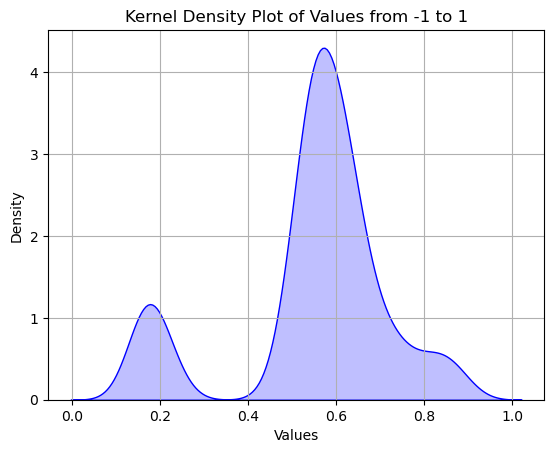

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

Max_List = dft['Max'].values

sns.kdeplot(Max_List, color='blue', shade=True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Values from -1 to 1')
plt.grid(True)
plt.show()

/tmp/ipykernel_4940/1862721131.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Min_List, color='blue', shade=True)


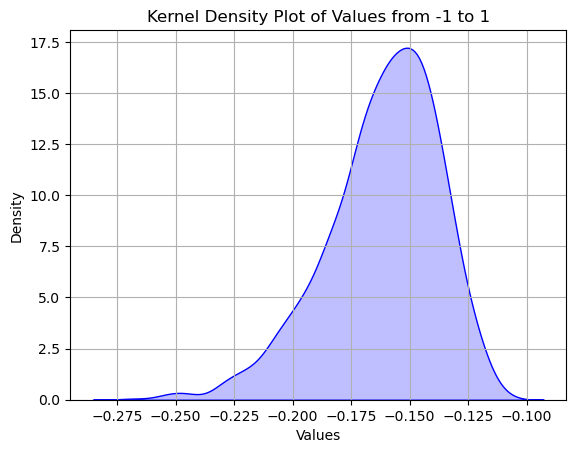

In [18]:
Min_List = dft['Min'].values

sns.kdeplot(Min_List, color='blue', shade=True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Values from -1 to 1')
plt.grid(True)
plt.show()

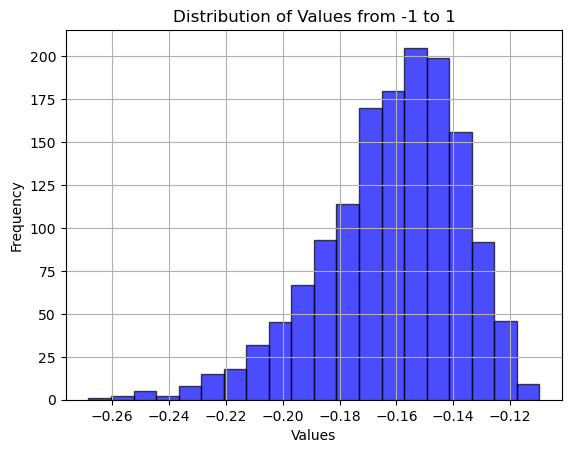

In [19]:
plt.hist(Min_List, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values from -1 to 1')
plt.grid(True)
plt.show()

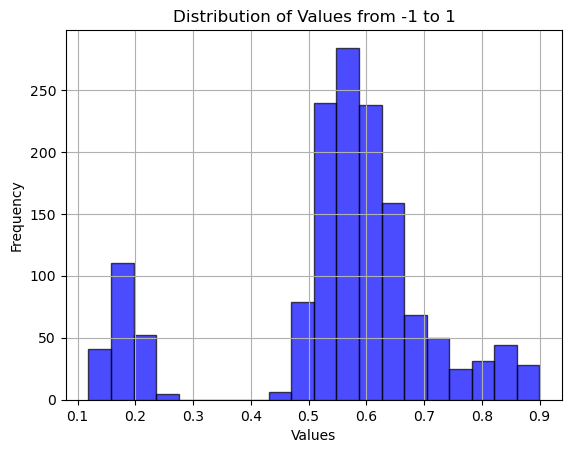

In [20]:
plt.hist(Max_List, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values from -1 to 1')
plt.grid(True)
plt.show()

In [21]:
dfscript.rename(columns={0: 'Title'}, inplace= True)
dfscript

,Title,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,No Country for Old Men,0.435468,-0.714977,-0.837122,0.450741,-0.462416,-0.906982,-0.765635,-0.708974,-0.702929,...,1.015948,0.330930,-1.697959,0.168485,-0.647523,2.100186,0.129689,-1.543718,2.065264,-1.921636
1,Jerry Maguire,-0.444837,0.159324,-0.388913,1.491390,-1.308448,-0.889009,0.431278,1.047363,1.499966,...,1.278180,-0.656330,0.901624,-0.417307,0.237089,-0.505310,0.319929,-1.942865,-0.492202,0.105615
2,Addams Family The,-0.268302,-2.083313,-1.680452,-1.948718,-0.950589,-0.147766,-1.822482,-1.085619,-0.987802,...,0.154331,-0.143344,2.480623,-2.574747,1.469676,0.010693,1.726077,0.932138,-0.886900,-1.041390
3,Machine Gun Preacher,0.307420,-0.100496,-2.566645,-1.411086,-0.779365,2.592604,-1.265630,-1.215639,1.003062,...,-0.762303,0.563558,0.916481,0.166525,-0.390272,0.803133,2.026479,-1.436558,-0.900736,0.103166
4,Things My Father Never Taught Me The,-0.083978,0.021037,-1.278945,0.544671,-1.478524,0.574162,-0.250923,-0.149791,-1.041891,...,-0.319937,1.030250,0.529061,-0.856804,0.432573,0.294090,-0.181518,-0.913402,-0.125193,-0.829323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,The Woodsman,-2.656661,-0.376801,-2.232772,-1.828810,-0.847536,-0.025481,-2.909357,-1.361267,-1.056639,...,-2.878319,-0.094368,-2.279826,-0.183496,-0.286352,-0.714658,1.375462,-1.793119,3.242983,-1.276183
2055,Avenge,2.848112,0.367793,2.267170,-0.886460,-2.648886,1.531821,-0.863337,0.212749,-2.304888,...,-1.429550,0.541675,-1.394171,-4.455475,2.621124,1.227030,1.971723,4.170731,1.204084,-1.009787
2056,An American Tragedy,-0.358636,-2.364026,-1.044511,-0.470538,-0.774473,2.504066,-1.671997,1.141534,-2.968049,...,1.756623,-0.167593,2.844471,-0.915697,-0.806426,0.668874,1.234839,-2.784548,-1.687161,0.189842
2057,Highlander 4,-0.024249,0.342495,-1.962474,0.068750,-2.488323,-0.331723,-0.781518,0.514518,2.069801,...,-3.994119,4.133815,0.969369,0.724297,2.244447,0.589505,0.385240,-0.808743,3.217748,-3.383243


In [22]:

from sklearn.cluster import KMeans

try:
    dfscript.drop(['cluster'])
except:
    pass

X = dfscript.iloc[:, 1:].values  


num_clusters = 40


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
dfscript['cluster'] = kmeans.fit_predict(X)


/home/gustamatos/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8696c2f240>
Traceback (most recent call last):
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in 

In [23]:
def recommend(movie_selected):
    if type(movie_selected) == str:
        movie_selected = [movie_selected]

    watched_movies_vectors = dfscript[dfscript['Title'].isin(movie_selected)].iloc[:, 1:-1].values
    average_vector = watched_movies_vectors.mean(axis=0)

    watched_movies_cluster = kmeans.predict([average_vector])

    cluster_movies = dfscript[dfscript['cluster'] == watched_movies_cluster[0]]
    cluster_movies = cluster_movies[~cluster_movies['Title'].isin(movie_selected)]

    similarities = cosine_similarity([average_vector], cluster_movies.iloc[:, 1:-1].values)
    cluster_movies['similarity'] = similarities[0]

    cluster_movies = cluster_movies.sort_values(by='similarity', ascending=False)

    top_recommendations = cluster_movies[['Title', 'similarity']].head(5)
    print(f"Top Recommendations for '{movie_selected}':")

    return print(top_recommendations)

In [24]:
recommend(['No Country for Old Men', 'Mean Girls'])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87e306d1c0>
Traceback (most recent call last):
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' ob

Top Recommendations for '['No Country for Old Men', 'Mean Girls']':
                   Title  similarity
1003  The Usual Suspects    0.477574
1546           Life Aqua    0.465681
1181       Apartment The    0.455532
1639          Karate Kid    0.450254
1322    Orgy of the Dead    0.436348
